# Part 3 - Sparse Learning

## Libraries

In [318]:
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

## Data Generator

In [229]:
def generate_data(m, n, algorithm=None):
    '''
    Function to generate a m×n sample set S. 
    Each elements of X are sampled uniformly at random from  {-1,1} (or from {0,1} for the Winnow algorithm).
    Labels y are the first elements of the correpsonding samples.
    m: number of samples
    n: dimension of each sample
    '''
    if algorithm == winnow:
        X = np.random.choice([0, 1], (m, n))
    else:
        X = np.random.choice([-1,1], size=(m,n))      
    y = X[:,0]                                     
    return X, y

## Algorithms

In [208]:
def least_square(X_train, y_train, X_test):
    '''
    Function to train a least square linear regression model on X_train and y_train and make predictions for X_test.
    X_train: training data
    y_train: training labels
    X_test: test data  
    '''
    W = np.dot(np.linalg.pinv(X_train), y_train)    #compute the weights (as a limiting case of ridge regression)
    y_pred = np.sign(np.dot(X_test, W))             #make predictions for the test data
    return y_pred

def perceptron(X_train, y_train, X_test, epochs=5):
    '''
    Function to train a perceptron algorithm on X_train and y_train and make predictions for X_test.
    X_train: training data
    y_train: training labels
    X_test: test data
    '''
    m, n = X_train.shape[0], X_train.shape[1]      #sizes of the training data
    W = np.zeros(n)                                #initialize the weights
    for epoch in range(epochs):                    #train the algorithm over multiple epochs
        for i in range(m):                         #receive the training samples sequentially
            X_i, y_i = X_train[i], y_train[i]      #obtain the ith training sample
            y_pred_i = np.sign(W.dot(X_i))         #make prediction for the ith training sample
            if y_pred_i != y_i:                    #if the prediction does not match the true label
                W += y_i * X_i                     #update the weights
    y_pred = np.sign(np.dot(X_test, W))            #make predictions for the test data
    return y_pred

def winnow(X_train, y_train, X_test, epochs=5):
    '''
    Function to train a winnow algorithm on X_train and y_train and make predictions for X_test.
    X_train: training data
    y_train: training labels
    X_test: test data  
    '''
    m, n = X_train.shape[0], X_train.shape[1]         #sizes of the training data
    W = np.ones(n)                                    #initialize the weights
    for epoch in range(epochs):                       #train the algorithm over multiple epochs
        for i in range(m):                            #receive the training samples sequentially
            X_i, y_i = X_train[i], y_train[i]         #obtain the ith training sample
            y_pred_i = 1 if W.dot(X_i) >= n else 0    #make prediction for the ith training sample
            if  y_pred_i != y_i:                      #if the prediction does not match the true label
                W *= float(2)**((y_i-y_pred_i)*X_i)   #update the weights
    y_pred = np.where(np.dot(X_test,W)>=n, 1, 0)      #make predictions for the test data
    return y_pred

def one_nearest_neighbour(X_train, y_train, X_test):
    '''
    Function to train a 1-NN algorithm on X_train and y_train and make predictions for X_test.
    X_train: training data
    y_train: training labels
    X_test: test data  
    '''
    #sizes of the training and test data
    m_train, n, m_test = X_train.shape[0], X_train.shape[1], X_test.shape[0]     
    #distance between a and b: (a-b)^2 = a∙a + b∙b - 2a∙b
    A_dots = (X_train*X_train).sum(axis=1).reshape((m_train,1))*np.ones(shape=(1,m_test))
    B_dots = (X_test*X_test).sum(axis=1)*np.ones(shape=(m_train,1))
    D = A_dots + B_dots - 2*X_train.dot(X_test.T)
    #make predictions based on the labels of the neareast neigbours
    y_pred = y_train[D.argmin(axis=0)]
    return y_pred

## Sample Complexity Calculator

In [345]:
def compute_empirical_error(y_pred, y_true):
    '''
    Function to compute the empirical error on the test set.
    y_pred: predictions
    y_true: true labels
    '''
    error_rates = sum(y_pred!=y_true) / len(y_true)
    return error_rates

def compute_bound(target_error, delta, test_size=2000):
    '''
    Function to compute the (1-delta)% confidence bound for the generalization error.
    target_error: the maximum generalization error expected
    delta: 1 - condifence 
    test_size: size of the test set where the empirical error is computed on.
    '''
    bound = target_error - np.sqrt(np.log(1/delta)/(2*test_size))
    return bound

def compute_sample_complexity(error_bound, runs, n_list, algorithm, n_train=10000, n_test=2000):
    '''
    Function to find the sample complexities of a given algorithm at different data dimensions.
    error_bound: the maximum generalization error
    runs: number of runs to obtain the average genralization error 
    n_list: list of dimensions to be tested over
    algorithm: the tested algorithm
    n_train: maximum number of training samples
    n_test: number of test samples
    '''
    C_list = [0] * len(n_list)              #initialize a list to store the sample complexities at different n values
    for n in tqdm(n_list):                  #for each n value
        for m in range(1, n_train+1):       #iteratively increase the size of the training data
            errors = []
            for run in range(runs):         #for each run
                X_train, y_train = generate_data(m, n, algorithm)         #generate the training data
                X_test, y_test = generate_data(n_test, n, algorithm)           #generate the test data
                y_pred = algorithm(X_train, y_train, X_test)              #train the algorithm and make predictions
                empirical_e = compute_empirical_error(y_pred, y_test)     #compute the empirical error on the test set
                errors.append(empirical_e)
            if np.mean(errors) <= error_bound:             #if the empirical error is less that the
                C_list[n-1] = m
                print('For dimension', n, 'the estimated training size is:', m)
                break
    return C_list

def plot_sample_complexity(n_list, C_list, name):
    '''
    Function to plot the sample complexity as a function of the dimension of data.
    n_list: list of dimensions
    C_list: list of sample complexitites
    name: name of the algorithm
    '''
    #choose the type of curve to fit over the data
    if name == 'Least Square' or name == 'Perceptron':
        F = linear_F
    elif name == 'Winnow':
        F = logarithmic_F
    else:
        F = exponential_F
    #compute the coefficients of the best fit curve
    coef, covariance = curve_fit(F, n_list, C_list)
    std = np.sqrt(np.diagonal(covariance))
    #compute the y-values of the fitted curve
    y_fitted = F(n_list, coef[0], coef[1])
    #plot the sample complexity and the best fit curve
    plt.figure(figsize=(7,5))
    plt.plot(n_list, C_list)
    plt.plot(n_list, y_fitted, 'r-', label='fitted curve')
    plt.legend()
    plt.xlabel('Dimension (n)', fontsize=12)
    plt.ylabel('Sample Complexity (m)', fontsize=12)
    plt.title('Sample Complexity of the ' + name + ' Algorithm', fontsize=14)
    plt.show()
    
def linear_F(x, a0, a1):
    return a0 + a1*x

def logarithmic_F(x, a0, a1):
    return a0 + a1*np.log10(x)

def exponential_F(x, a0, a1):
    return a0*np.exp(x)

## Least Square

In [277]:
runs = 5
delta = 0.05
target_error = 0.1
n_list = np.arange(1,101)
#n_train=10000, n_test=2000
error_bound = compute_bound(target_error, delta)
error_bound

0.07263335847444014

In [279]:
LR_C_list = compute_sample_complexity(error_bound, runs, n_list, least_square)

  6%|████▉                                                                             | 6/100 [00:00<00:01, 48.84it/s]

For dimension 1 the estimated training size is: 1
For dimension 2 the estimated training size is: 2
For dimension 3 the estimated training size is: 3
For dimension 4 the estimated training size is: 5
For dimension 5 the estimated training size is: 5
For dimension 6 the estimated training size is: 7
For dimension 7 the estimated training size is: 6
For dimension

 11%|████████▉                                                                        | 11/100 [00:00<00:02, 36.80it/s]

 8 the estimated training size is: 8
For dimension 9 the estimated training size is: 7
For dimension 10 the estimated training size is: 8
For dimension 11 the estimated training size is: 8
For dimension 12 the estimated training size is: 9
For dimension 13 the estimated training size is: 10
For dimension 14 the estimated training size is: 9


 15%|████████████▏                                                                    | 15/100 [00:00<00:02, 33.15it/s]

For dimension 15 the estimated training size is: 12
For dimension 16 the estimated training size is: 11
For dimension 17 the estimated training size is: 13
For dimension 18 the estimated training size is: 14


 19%|███████████████▍                                                                 | 19/100 [00:00<00:03, 23.19it/s]

For dimension 19 the estimated training size is: 13
For dimension 20 the estimated training size is: 14
For dimension 21 the estimated training size is: 15


 22%|█████████████████▊                                                               | 22/100 [00:00<00:04, 17.18it/s]

For dimension 22 the estimated training size is: 15
For dimension 23 the estimated training size is: 15


 25%|████████████████████▎                                                            | 25/100 [00:01<00:05, 13.51it/s]

For dimension 24 the estimated training size is: 17
For dimension 25 the estimated training size is: 16


 27%|█████████████████████▊                                                           | 27/100 [00:01<00:06, 11.42it/s]

For dimension 26 the estimated training size is: 19
For dimension 27 the estimated training size is: 17


 29%|███████████████████████▍                                                         | 29/100 [00:01<00:07,  9.67it/s]

For dimension 28 the estimated training size is: 19
For dimension 29 the estimated training size is: 20


 31%|█████████████████████████                                                        | 31/100 [00:02<00:08,  8.44it/s]

For dimension 30 the estimated training size is: 20
For dimension 31 the estimated training size is: 21


 33%|██████████████████████████▋                                                      | 33/100 [00:02<00:09,  7.42it/s]

For dimension 32 the estimated training size is: 20
For dimension 33 the estimated training size is: 23


 34%|███████████████████████████▌                                                     | 34/100 [00:02<00:09,  6.96it/s]

For dimension 34 the estimated training size is: 24


 35%|████████████████████████████▎                                                    | 35/100 [00:02<00:10,  6.21it/s]

For dimension 35 the estimated training size is: 25


 36%|█████████████████████████████▏                                                   | 36/100 [00:03<00:13,  4.87it/s]

For dimension 36 the estimated training size is: 24


 37%|█████████████████████████████▉                                                   | 37/100 [00:03<00:13,  4.71it/s]

For dimension 37 the estimated training size is: 24


 38%|██████████████████████████████▊                                                  | 38/100 [00:03<00:15,  3.90it/s]

For dimension 38 the estimated training size is: 27


 39%|███████████████████████████████▌                                                 | 39/100 [00:04<00:17,  3.52it/s]

For dimension 39 the estimated training size is: 27


 40%|████████████████████████████████▍                                                | 40/100 [00:04<00:16,  3.57it/s]

For dimension 40 the estimated training size is: 27


 41%|█████████████████████████████████▏                                               | 41/100 [00:04<00:16,  3.59it/s]

For dimension 41 the estimated training size is: 27


 42%|██████████████████████████████████                                               | 42/100 [00:05<00:16,  3.47it/s]

For dimension 42 the estimated training size is: 29


 43%|██████████████████████████████████▊                                              | 43/100 [00:05<00:15,  3.63it/s]

For dimension 43 the estimated training size is: 24


 44%|███████████████████████████████████▋                                             | 44/100 [00:05<00:15,  3.53it/s]

For dimension 44 the estimated training size is: 30


 45%|████████████████████████████████████▍                                            | 45/100 [00:06<00:16,  3.26it/s]

For dimension 45 the estimated training size is: 30


 46%|█████████████████████████████████████▎                                           | 46/100 [00:06<00:18,  2.94it/s]

For dimension 46 the estimated training size is: 33


 47%|██████████████████████████████████████                                           | 47/100 [00:06<00:17,  2.97it/s]

For dimension 47 the estimated training size is: 32


 48%|██████████████████████████████████████▉                                          | 48/100 [00:07<00:17,  2.95it/s]

For dimension 48 the estimated training size is: 35


 49%|███████████████████████████████████████▋                                         | 49/100 [00:07<00:17,  2.98it/s]

For dimension 49 the estimated training size is: 34


 50%|████████████████████████████████████████▌                                        | 50/100 [00:07<00:17,  2.87it/s]

For dimension 50 the estimated training size is: 34


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:08<00:17,  2.85it/s]

For dimension 51 the estimated training size is: 37


 52%|██████████████████████████████████████████                                       | 52/100 [00:08<00:16,  2.86it/s]

For dimension 52 the estimated training size is: 34


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:08<00:16,  2.87it/s]

For dimension 53 the estimated training size is: 35


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:09<00:16,  2.87it/s]

For dimension 54 the estimated training size is: 33


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:09<00:17,  2.55it/s]

For dimension 55 the estimated training size is: 39


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:10<00:18,  2.33it/s]

For dimension 56 the estimated training size is: 38


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:10<00:18,  2.35it/s]

For dimension 57 the estimated training size is: 37


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:11<00:17,  2.37it/s]

For dimension 58 the estimated training size is: 38


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:11<00:17,  2.35it/s]

For dimension 59 the estimated training size is: 39


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:12<00:17,  2.27it/s]

For dimension 60 the estimated training size is: 42


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:12<00:17,  2.17it/s]

For dimension 61 the estimated training size is: 42


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:13<00:19,  1.93it/s]

For dimension 62 the estimated training size is: 42


 63%|███████████████████████████████████████████████████                              | 63/100 [00:14<00:23,  1.59it/s]

For dimension 63 the estimated training size is: 44


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:14<00:25,  1.39it/s]

For dimension 64 the estimated training size is: 46


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:15<00:24,  1.41it/s]

For dimension 65 the estimated training size is: 43


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:16<00:23,  1.44it/s]

For dimension 66 the estimated training size is: 45


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:17<00:23,  1.39it/s]

For dimension 67 the estimated training size is: 48


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:17<00:21,  1.47it/s]

For dimension 68 the estimated training size is: 43


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:18<00:21,  1.45it/s]

For dimension 69 the estimated training size is: 46


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:19<00:21,  1.40it/s]

For dimension 70 the estimated training size is: 47


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:19<00:21,  1.34it/s]

For dimension 71 the estimated training size is: 48


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:20<00:21,  1.28it/s]

For dimension 72 the estimated training size is: 49


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:21<00:21,  1.23it/s]

For dimension 73 the estimated training size is: 51


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:22<00:21,  1.20it/s]

For dimension 74 the estimated training size is: 49


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:23<00:21,  1.16it/s]

For dimension 75 the estimated training size is: 50


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:24<00:20,  1.14it/s]

For dimension 76 the estimated training size is: 50


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:25<00:20,  1.12it/s]

For dimension 77 the estimated training size is: 50


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:26<00:20,  1.08it/s]

For dimension 78 the estimated training size is: 52


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:27<00:21,  1.01s/it]

For dimension 79 the estimated training size is: 55


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:28<00:20,  1.03s/it]

For dimension 80 the estimated training size is: 54


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:29<00:20,  1.08s/it]

For dimension 81 the estimated training size is: 55


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:30<00:19,  1.07s/it]

For dimension 82 the estimated training size is: 58


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [00:31<00:17,  1.02s/it]

For dimension 83 the estimated training size is: 54


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:32<00:16,  1.01s/it]

For dimension 84 the estimated training size is: 57


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:33<00:15,  1.04s/it]

For dimension 85 the estimated training size is: 55


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:35<00:14,  1.06s/it]

For dimension 86 the estimated training size is: 59


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:36<00:15,  1.21s/it]

For dimension 87 the estimated training size is: 60


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:37<00:14,  1.22s/it]

For dimension 88 the estimated training size is: 57


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [00:39<00:14,  1.31s/it]

For dimension 89 the estimated training size is: 62


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:40<00:13,  1.37s/it]

For dimension 90 the estimated training size is: 60


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:42<00:13,  1.54s/it]

For dimension 91 the estimated training size is: 61


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:44<00:13,  1.64s/it]

For dimension 92 the estimated training size is: 60


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [00:46<00:11,  1.71s/it]

For dimension 93 the estimated training size is: 65


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:47<00:09,  1.63s/it]

For dimension 94 the estimated training size is: 63


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:49<00:08,  1.62s/it]

For dimension 95 the estimated training size is: 64


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:51<00:06,  1.58s/it]

For dimension 96 the estimated training size is: 63


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:52<00:05,  1.68s/it]

For dimension 97 the estimated training size is: 61


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:54<00:03,  1.78s/it]

For dimension 98 the estimated training size is: 66


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:56<00:01,  1.84s/it]

For dimension 99 the estimated training size is: 67


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.69it/s]

For dimension 100 the estimated training size is: 67


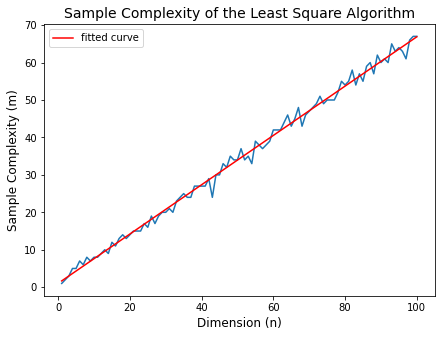

In [346]:
n_list = np.arange(1,101)
plot_sample_complexity(n_list, LR_C_list, 'Least Square')

## Perceptron

In [280]:
runs = 5
delta = 0.05
target_error = 0.1
n_list = np.arange(1,101)
#n_train=10000, n_test=2000
error_bound = compute_bound(target_error, delta)
error_bound

0.07263335847444014

In [281]:
perceptron_C_list = compute_sample_complexity(error_bound, runs, n_list, perceptron)

  6%|████▉                                                                             | 6/100 [00:00<00:01, 50.01it/s]

For dimension 1 the estimated training size is: 1
For dimension 2 the estimated training size is: 3
For dimension 3 the estimated training size is: 7
For dimension 4 the estimated training size is: 7
For dimension 5 the estimated training size is: 5
For dimension 6 the estimated training size is: 11
For dimension 7 the estimated training size is: 7
For dimension 8 the estimated training size is: 11
For dimension 9 the estimated training size is: 11
For dimension 10 the estimated training size is: 11
For dimension

 12%|█████████▋                                                                       | 12/100 [00:00<00:04, 21.25it/s]

 11 the estimated training size is: 14
For dimension 12 the estimated training size is: 16
For dimension 13 the estimated training size is: 20
For dimension 14 the estimated training size is: 19


 15%|████████████▏                                                                    | 15/100 [00:00<00:05, 14.30it/s]

For dimension 15 the estimated training size is: 21
For dimension 16 the estimated training size is: 26


 17%|█████████████▊                                                                   | 17/100 [00:01<00:07, 11.45it/s]

For dimension 17 the estimated training size is: 27
For dimension 18 the estimated training size is: 27
For dimension

 19%|███████████████▍                                                                 | 19/100 [00:01<00:09,  8.91it/s]

 19 the estimated training size is: 26
For dimension 20 the estimated training size is: 29


 21%|█████████████████                                                                | 21/100 [00:02<00:11,  6.99it/s]

For dimension 21 the estimated training size is: 30


 22%|█████████████████▊                                                               | 22/100 [00:02<00:12,  6.36it/s]

For dimension 22 the estimated training size is: 30


 23%|██████████████████▋                                                              | 23/100 [00:02<00:13,  5.86it/s]

For dimension 23 the estimated training size is: 27


 24%|███████████████████▍                                                             | 24/100 [00:02<00:13,  5.48it/s]

For dimension 24 the estimated training size is: 29


 25%|████████████████████▎                                                            | 25/100 [00:02<00:15,  4.97it/s]

For dimension 25 the estimated training size is: 33


 26%|█████████████████████                                                            | 26/100 [00:03<00:16,  4.42it/s]

For dimension 26 the estimated training size is: 38


 27%|█████████████████████▊                                                           | 27/100 [00:03<00:16,  4.32it/s]

For dimension 27 the estimated training size is: 34


 28%|██████████████████████▋                                                          | 28/100 [00:03<00:17,  4.19it/s]

For dimension 28 the estimated training size is: 36


 29%|███████████████████████▍                                                         | 29/100 [00:04<00:18,  3.84it/s]

For dimension 29 the estimated training size is: 38


 30%|████████████████████████▎                                                        | 30/100 [00:04<00:18,  3.81it/s]

For dimension 30 the estimated training size is: 33


 31%|█████████████████████████                                                        | 31/100 [00:04<00:21,  3.28it/s]

For dimension 31 the estimated training size is: 48


 32%|█████████████████████████▉                                                       | 32/100 [00:05<00:20,  3.29it/s]

For dimension 32 the estimated training size is: 39


 33%|██████████████████████████▋                                                      | 33/100 [00:05<00:20,  3.34it/s]

For dimension 33 the estimated training size is: 40


 34%|███████████████████████████▌                                                     | 34/100 [00:05<00:21,  3.08it/s]

For dimension 34 the estimated training size is: 51


 35%|████████████████████████████▎                                                    | 35/100 [00:06<00:22,  2.92it/s]

For dimension 35 the estimated training size is: 49


 36%|█████████████████████████████▏                                                   | 36/100 [00:06<00:22,  2.80it/s]

For dimension 36 the estimated training size is: 46


 37%|█████████████████████████████▉                                                   | 37/100 [00:06<00:23,  2.65it/s]

For dimension 37 the estimated training size is: 48


 38%|██████████████████████████████▊                                                  | 38/100 [00:07<00:23,  2.62it/s]

For dimension 38 the estimated training size is: 48


 39%|███████████████████████████████▌                                                 | 39/100 [00:07<00:25,  2.35it/s]

For dimension 39 the estimated training size is: 56


 40%|████████████████████████████████▍                                                | 40/100 [00:08<00:26,  2.23it/s]

For dimension 40 the estimated training size is: 56


 41%|█████████████████████████████████▏                                               | 41/100 [00:08<00:27,  2.12it/s]

For dimension 41 the estimated training size is: 57


 42%|██████████████████████████████████                                               | 42/100 [00:09<00:28,  2.04it/s]

For dimension 42 the estimated training size is: 53


 43%|██████████████████████████████████▊                                              | 43/100 [00:10<00:29,  1.95it/s]

For dimension 43 the estimated training size is: 58


 44%|███████████████████████████████████▋                                             | 44/100 [00:10<00:30,  1.86it/s]

For dimension 44 the estimated training size is: 61


 45%|████████████████████████████████████▍                                            | 45/100 [00:11<00:32,  1.69it/s]

For dimension 45 the estimated training size is: 59


 46%|█████████████████████████████████████▎                                           | 46/100 [00:12<00:35,  1.51it/s]

For dimension 46 the estimated training size is: 64


 47%|██████████████████████████████████████                                           | 47/100 [00:13<00:37,  1.40it/s]

For dimension 47 the estimated training size is: 64


 48%|██████████████████████████████████████▉                                          | 48/100 [00:13<00:37,  1.40it/s]

For dimension 48 the estimated training size is: 67


 49%|███████████████████████████████████████▋                                         | 49/100 [00:14<00:37,  1.36it/s]

For dimension 49 the estimated training size is: 63


 50%|████████████████████████████████████████▌                                        | 50/100 [00:15<00:39,  1.27it/s]

For dimension 50 the estimated training size is: 72


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:16<00:37,  1.30it/s]

For dimension 51 the estimated training size is: 66


 52%|██████████████████████████████████████████                                       | 52/100 [00:16<00:36,  1.31it/s]

For dimension 52 the estimated training size is: 71


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:17<00:36,  1.28it/s]

For dimension 53 the estimated training size is: 73


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:18<00:38,  1.19it/s]

For dimension 54 the estimated training size is: 74


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:19<00:38,  1.16it/s]

For dimension 55 the estimated training size is: 70


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:20<00:41,  1.07it/s]

For dimension 56 the estimated training size is: 77


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:21<00:41,  1.03it/s]

For dimension 57 the estimated training size is: 73


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:22<00:41,  1.01it/s]

For dimension 58 the estimated training size is: 74


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:23<00:39,  1.03it/s]

For dimension 59 the estimated training size is: 76


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:24<00:40,  1.01s/it]

For dimension 60 the estimated training size is: 81


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:25<00:39,  1.02s/it]

For dimension 61 the estimated training size is: 80


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:26<00:39,  1.03s/it]

For dimension 62 the estimated training size is: 82


 63%|███████████████████████████████████████████████████                              | 63/100 [00:28<00:39,  1.08s/it]

For dimension 63 the estimated training size is: 84


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:29<00:41,  1.15s/it]

For dimension 64 the estimated training size is: 90


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:30<00:42,  1.20s/it]

For dimension 65 the estimated training size is: 88


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:32<00:42,  1.25s/it]

For dimension 66 the estimated training size is: 86


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:33<00:41,  1.25s/it]

For dimension 67 the estimated training size is: 84


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:34<00:41,  1.30s/it]

For dimension 68 the estimated training size is: 93


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:35<00:39,  1.26s/it]

For dimension 69 the estimated training size is: 80


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:37<00:37,  1.26s/it]

For dimension 70 the estimated training size is: 88


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:38<00:38,  1.34s/it]

For dimension 71 the estimated training size is: 95


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:40<00:40,  1.46s/it]

For dimension 72 the estimated training size is: 101


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:42<00:41,  1.53s/it]

For dimension 73 the estimated training size is: 100


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:43<00:40,  1.57s/it]

For dimension 74 the estimated training size is: 102


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:45<00:39,  1.59s/it]

For dimension 75 the estimated training size is: 104


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:47<00:37,  1.58s/it]

For dimension 76 the estimated training size is: 96


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:48<00:36,  1.59s/it]

For dimension 77 the estimated training size is: 94


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:50<00:35,  1.60s/it]

For dimension 78 the estimated training size is: 98


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:51<00:33,  1.60s/it]

For dimension 79 the estimated training size is: 94


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:53<00:34,  1.71s/it]

For dimension 80 the estimated training size is: 104


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:55<00:32,  1.73s/it]

For dimension 81 the estimated training size is: 106


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:57<00:31,  1.72s/it]

For dimension 82 the estimated training size is: 106


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [00:59<00:29,  1.75s/it]

For dimension 83 the estimated training size is: 106


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [01:01<00:29,  1.84s/it]

For dimension 84 the estimated training size is: 114


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [01:03<00:29,  1.98s/it]

For dimension 85 the estimated training size is: 112


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [01:05<00:27,  1.98s/it]

For dimension 86 the estimated training size is: 108


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [01:07<00:26,  2.06s/it]

For dimension 87 the estimated training size is: 117


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [01:09<00:24,  2.06s/it]

For dimension 88 the estimated training size is: 113


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [01:11<00:23,  2.11s/it]

For dimension 89 the estimated training size is: 113


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [01:14<00:22,  2.23s/it]

For dimension 90 the estimated training size is: 120


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [01:16<00:20,  2.28s/it]

For dimension 91 the estimated training size is: 120


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [01:19<00:19,  2.41s/it]

For dimension 92 the estimated training size is: 124


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [01:22<00:17,  2.51s/it]

For dimension 93 the estimated training size is: 127


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [01:24<00:14,  2.46s/it]

For dimension 94 the estimated training size is: 121


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [01:27<00:12,  2.49s/it]

For dimension 95 the estimated training size is: 127


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [01:29<00:10,  2.54s/it]

For dimension 96 the estimated training size is: 125


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [01:32<00:08,  2.70s/it]

For dimension 97 the estimated training size is: 129


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [01:35<00:05,  2.67s/it]

For dimension 98 the estimated training size is: 125


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:38<00:02,  2.64s/it]

For dimension 99 the estimated training size is: 129


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.01s/it]

For dimension 100 the estimated training size is: 141


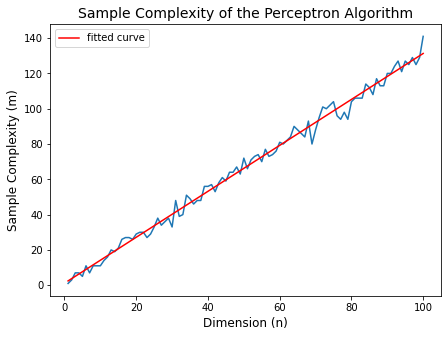

In [347]:
n_list = np.arange(1,101)
plot_sample_complexity(n_list, perceptron_C_list, 'Perceptron')

## Winnow

In [286]:
runs = 5
delta = 0.05
target_error = 0.1
n_list = np.arange(1,101)
#n_train=10000, n_test=2000
error_bound = compute_bound(target_error, delta)
error_bound

0.07263335847444014

In [287]:
winnow_C_list = compute_sample_complexity(error_bound, runs, n_list, winnow)

  5%|████                                                                              | 5/100 [00:00<00:02, 38.45it/s]

For dimension 1 the estimated training size is: 1
For dimension 2 the estimated training size is: 7
For dimension 3 the estimated training size is: 10
For dimension 4 the estimated training size is: 7
For dimension 5 the estimated training size is: 9
For dimension 6 the estimated training size is: 11


  9%|███████▍                                                                          | 9/100 [00:00<00:04, 22.66it/s]

For dimension 7 the estimated training size is: 11
For dimension 8 the estimated training size is: 9
For dimension 9 the estimated training size is: 10
For dimension 10 the estimated training size is: 11
For dimension 11 the estimated training size is: 15


 15%|████████████▏                                                                    | 15/100 [00:00<00:04, 20.40it/s]

For dimension 12 the estimated training size is: 15
For dimension 13 the estimated training size is: 10
For dimension 14 the estimated training size is: 15
For dimension 15 the estimated training size is: 17


 18%|██████████████▌                                                                  | 18/100 [00:00<00:04, 16.93it/s]

For dimension 16 the estimated training size is: 14
For dimension 17 the estimated training size is: 15
For dimension 18 the estimated training size is: 17


 20%|████████████████▏                                                                | 20/100 [00:01<00:05, 15.53it/s]

For dimension 19 the estimated training size is: 14
For dimension 20 the estimated training size is: 13
For dimension 21 the estimated training size is: 13


 24%|███████████████████▍                                                             | 24/100 [00:01<00:05, 13.86it/s]

For dimension 22 the estimated training size is: 16
For dimension 23 the estimated training size is: 13
For dimension 24 the estimated training size is: 14


 26%|█████████████████████                                                            | 26/100 [00:01<00:05, 13.04it/s]

For dimension 25 the estimated training size is: 13
For dimension 26 the estimated training size is: 15


 28%|██████████████████████▋                                                          | 28/100 [00:01<00:06, 11.75it/s]

For dimension 27 the estimated training size is: 18
For dimension 28 the estimated training size is: 16
For dimension

 30%|████████████████████████▎                                                        | 30/100 [00:01<00:06, 11.35it/s]

 29 the estimated training size is: 14
For dimension 30 the estimated training size is: 15
For dimension

 32%|█████████████████████████▉                                                       | 32/100 [00:02<00:06, 11.23it/s]

 31 the estimated training size is: 13
For dimension 32 the estimated training size is: 15
For dimension

 34%|███████████████████████████▌                                                     | 34/100 [00:02<00:06, 10.17it/s]

 33 the estimated training size is: 16
For dimension 34 the estimated training size is: 20


 36%|█████████████████████████████▏                                                   | 36/100 [00:02<00:06,  9.40it/s]

For dimension 35 the estimated training size is: 17
For dimension 36 the estimated training size is: 19


 38%|██████████████████████████████▊                                                  | 38/100 [00:02<00:07,  8.25it/s]

For dimension 37 the estimated training size is: 19
For dimension 38 the estimated training size is: 21


 40%|████████████████████████████████▍                                                | 40/100 [00:03<00:07,  8.47it/s]

For dimension 39 the estimated training size is: 15
For dimension 40 the estimated training size is: 16


 42%|██████████████████████████████████                                               | 42/100 [00:03<00:06,  8.34it/s]

For dimension 41 the estimated training size is: 17
For dimension 42 the estimated training size is: 15


 44%|███████████████████████████████████▋                                             | 44/100 [00:03<00:06,  8.45it/s]

For dimension 43 the estimated training size is: 16
For dimension 44 the estimated training size is: 17


 46%|█████████████████████████████████████▎                                           | 46/100 [00:03<00:07,  7.63it/s]

For dimension 45 the estimated training size is: 17
For dimension 46 the estimated training size is: 19


 48%|██████████████████████████████████████▉                                          | 48/100 [00:04<00:07,  7.28it/s]

For dimension 47 the estimated training size is: 19
For dimension 48 the estimated training size is: 17


 50%|████████████████████████████████████████▌                                        | 50/100 [00:04<00:06,  7.35it/s]

For dimension 49 the estimated training size is: 15
For dimension 50 the estimated training size is: 17


 52%|██████████████████████████████████████████                                       | 52/100 [00:04<00:07,  6.61it/s]

For dimension 51 the estimated training size is: 18
For dimension 52 the estimated training size is: 20


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:05<00:07,  6.48it/s]

For dimension 53 the estimated training size is: 18
For dimension 54 the estimated training size is: 17


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:05<00:07,  6.35it/s]

For dimension 55 the estimated training size is: 19
For dimension

 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:05<00:07,  5.83it/s]

 56 the estimated training size is: 20


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:05<00:07,  5.58it/s]

For dimension 57 the estimated training size is: 20
For dimension 58 the estimated training size is: 19


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:06<00:07,  5.84it/s]

For dimension 59 the estimated training size is: 17
For dimension 60 the estimated training size is: 

 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:06<00:06,  5.72it/s]

19
For dimension 61 the estimated training size is: 18


 63%|███████████████████████████████████████████████████                              | 63/100 [00:06<00:06,  5.57it/s]

For dimension 62 the estimated training size is: 18
For dimension 63 the estimated training size is: 19


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:06<00:06,  5.31it/s]

For dimension 64 the estimated training size is: 21


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:07<00:06,  5.02it/s]

For dimension 65 the estimated training size is: 22


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:07<00:06,  5.12it/s]

For dimension 66 the estimated training size is: 18
For dimension 67 the estimated training size is: 14


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:07<00:06,  4.84it/s]

For dimension 68 the estimated training size is: 18


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:08<00:06,  4.54it/s]

For dimension 69 the estimated training size is: 19


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:08<00:06,  4.53it/s]

For dimension 70 the estimated training size is: 18


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:08<00:06,  4.38it/s]

For dimension 71 the estimated training size is: 20


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:08<00:06,  4.43it/s]

For dimension 72 the estimated training size is: 19


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:09<00:06,  3.99it/s]

For dimension 73 the estimated training size is: 23


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:09<00:06,  4.12it/s]

For dimension 74 the estimated training size is: 17


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:09<00:05,  4.24it/s]

For dimension 75 the estimated training size is: 17


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:09<00:06,  3.97it/s]

For dimension 76 the estimated training size is: 20


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:10<00:05,  3.90it/s]

For dimension 77 the estimated training size is: 20


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:10<00:05,  3.74it/s]

For dimension 78 the estimated training size is: 21


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:10<00:05,  3.90it/s]

For dimension 79 the estimated training size is: 16


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:10<00:05,  3.52it/s]

For dimension 80 the estimated training size is: 24


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:11<00:05,  3.39it/s]

For dimension 81 the estimated training size is: 22


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:11<00:05,  3.43it/s]

For dimension 82 the estimated training size is: 20


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [00:11<00:04,  3.51it/s]

For dimension 83 the estimated training size is: 20


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:12<00:04,  3.37it/s]

For dimension 84 the estimated training size is: 22


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:12<00:04,  3.48it/s]

For dimension 85 the estimated training size is: 18


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:12<00:03,  3.61it/s]

For dimension 86 the estimated training size is: 18


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:12<00:03,  3.61it/s]

For dimension 87 the estimated training size is: 19


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:13<00:03,  3.72it/s]

For dimension 88 the estimated training size is: 17


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [00:13<00:03,  3.53it/s]

For dimension 89 the estimated training size is: 20


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:13<00:02,  3.65it/s]

For dimension 90 the estimated training size is: 16


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:14<00:02,  3.67it/s]

For dimension 91 the estimated training size is: 18


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:14<00:02,  3.55it/s]

For dimension 92 the estimated training size is: 20


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [00:14<00:01,  3.54it/s]

For dimension 93 the estimated training size is: 18


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:14<00:01,  3.63it/s]

For dimension 94 the estimated training size is: 16


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:15<00:01,  3.53it/s]

For dimension 95 the estimated training size is: 19


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:15<00:01,  3.29it/s]

For dimension 96 the estimated training size is: 20


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:15<00:00,  3.05it/s]

For dimension 97 the estimated training size is: 23


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:16<00:00,  2.94it/s]

For dimension 98 the estimated training size is: 22


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:16<00:00,  2.85it/s]

For dimension 99 the estimated training size is: 21


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.88it/s]

For dimension 100 the estimated training size is: 21


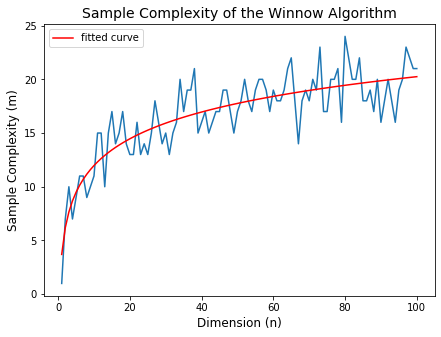

In [348]:
n_list = np.arange(1,101)
plot_sample_complexity(n_list, winnow_C_list, 'Winnow')

## 1-NN

In [289]:
runs = 5
delta = 0.05
target_error = 0.1
n_list = np.arange(1,17)
#n_train=10000, n_test=2000
error_bound = compute_bound(target_error, delta)
error_bound

0.07263335847444014

In [290]:
NN_C_list = compute_sample_complexity(error_bound, runs, n_list, one_nearest_neighbour)

 25%|████████████████████▊                                                              | 4/16 [00:00<00:00, 32.79it/s]

For dimension 1 the estimated training size is: 4
For dimension 2 the estimated training size is: 6
For dimension 3 the estimated training size is: 12
For dimension 4 the estimated training size is: 14
For dimension 5 the estimated training size is: 26
For dimension 6 the estimated training size is: 44
For dimension 7 the estimated training size is: 72


 50%|█████████████████████████████████████████▌                                         | 8/16 [00:02<00:03,  2.45it/s]

For dimension 8 the estimated training size is: 103
For dimension 9 the estimated training size is: 186


 62%|███████████████████████████████████████████████████▎                              | 10/16 [00:22<00:19,  3.27s/it]

For dimension 10 the estimated training size is: 290


 69%|████████████████████████████████████████████████████████▍                         | 11/16 [00:57<00:43,  8.72s/it]

For dimension 11 the estimated training size is: 477


 75%|█████████████████████████████████████████████████████████████▌                    | 12/16 [02:16<01:30, 22.67s/it]

For dimension 12 the estimated training size is: 715


 81%|██████████████████████████████████████████████████████████████████▋               | 13/16 [05:26<02:59, 59.78s/it]

For dimension 13 the estimated training size is: 1103


 88%|██████████████████████████████████████████████████████████████████████▉          | 14/16 [12:19<04:49, 144.93s/it]

For dimension 14 the estimated training size is: 1597


 94%|███████████████████████████████████████████████████████████████████████████▉     | 15/16 [33:28<07:12, 432.32s/it]

For dimension 15 the estimated training size is: 2710


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [1:26:02<00:00, 322.64s/it]

For dimension 16 the estimated training size is: 4167


C:\Users\ryanl\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


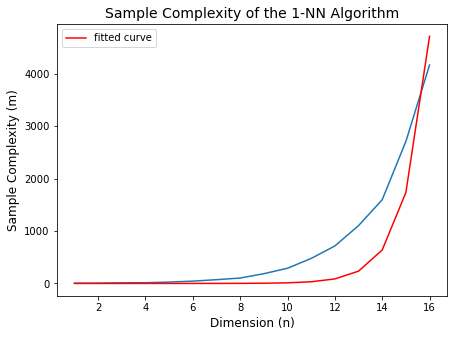

In [350]:
n_list = np.arange(1,17)
plot_sample_complexity(n_list, NN_C_list, '1-NN')